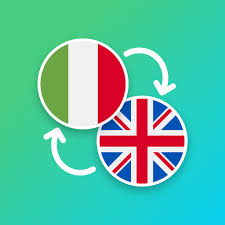

<p style="text-align: center; font-size: 30px;"><b>Italian Translator</b></p>

**Building an English-Italian Neural Machine Translator**

### **Project Overview**

This project implements a **sequence-to-sequence (seq2seq) neural machine translation system** that translates English sentences to Italian using deep learning.

**What we're building:**
- Encoder-decoder architecture with LSTM networks
- Trained on 5,000 English-Italian sentence pairs
- Word-by-word translation generation

**Core components:**
1. **Data preprocessing**: Tokenization, vocabulary building, one-hot encoding
2. **Encoder**: Compresses English sentences into meaning vectors
3. **Decoder**: Generates Italian translations from encoder states
4. **Training**: Model learns translation patterns over 100+ epochs
5. **Inference**: Word-by-word generation using trained models

**Key technologies:**
- **TensorFlow/Keras**: Neural network framework
- **LSTM layers**: Handle sequential language data
- **One-hot encoding**: Convert text to numerical format
- **Greedy decoding**: Generate translations word-by-word

**Learning goals:**
- Understand seq2seq architecture
- Master encoder-decoder connections
- Learn autoregressive generation
- Handle real-world NLP challenges (vocabulary size, overfitting, data quality)

**Expected outcome:**
A working translator that can accurately translate simple English sentences to Italian (for vocabulary seen during training).

---

Let's begin!

In [1]:
import numpy as np
import re
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model

2025-12-07 17:48:04.420943: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 17:48:04.440549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 17:48:04.569180: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 17:48:04.707707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765126084.835151   30725 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765126084.87

# **Data Loading and Preprocessing**

### **Purpose:**
Transform raw English-Italian text file into numerical matrices for neural network training.

---

### **Step 1: Load Raw Data**
```python
data_path = "ita.txt"
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
```
- Opens file with UTF-8 encoding (handles Italian accents)
- Splits into list of lines (each line = one translation pair)

---

### **Step 2: Initialize Data Structures**
```python
input_docs = []      # English sentences
target_docs = []     # Italian sentences
input_tokens = set() # Unique English words
target_tokens = set() # Unique Italian words
NUM_SAMPLES = 5000   # Use first 5000 sentences
```
- Lists store sentences; sets collect unique vocabulary
- 5000 sentences balances learning quality with memory usage

---

### **Step 3: Process Each Sentence**
```python
for line in lines[:NUM_SAMPLES]:
    input_doc, target_doc = line.split('\t')[:2]
```
- Splits line on tab: `"Go.\tVai."` → English: `"Go."`, Italian: `"Vai."`

**Tokenize (separate punctuation):**
```python
input_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", input_doc))
# "Go." → "Go ."
# "I'll try." → "I'll try ."
```

**Add special tokens to Italian:**
```python
target_doc = '<START> ' + target_doc + ' <END>'
# "Vai ." → "<START> Vai . <END>"
```
- `<START>` signals decoder to begin translation
- `<END>` signals when to stop generating

**Build vocabularies:**
```python
for token in input_doc.split():
    input_tokens.add(token)  # Sets auto-handle duplicates
```

---

### **Step 4: Prepare Vocabularies**
```python
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
```
- Sorting ensures consistent word→index mapping across runs
- Count total unique words in each language

**Calculate maximum sentence lengths:**
```python
max_encoder_seq_length = max([len(doc.split()) for doc in input_docs])
max_decoder_seq_length = max([len(doc.split()) for doc in target_docs])
```
- Finds longest sentence (all sentences padded to this length)

---

### **Step 5: Create Word↔Index Dictionaries**
```python
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
# {"Go": 0, "Hi": 1, "I": 2, ...}

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
# {0: "Go", 1: "Hi", 2: "I", ...}
```
- Forward dict: converts words to numbers (encoding)
- Reverse dict: converts numbers to words (decoding)

---

### **Step 6: Create Empty Training Matrices**
```python
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
```
**3D shape:**
- Dimension 1: Number of sentences (5000)
- Dimension 2: Max sentence length (e.g., 15 words)
- Dimension 3: Vocabulary size (e.g., 939 English words)

**Three matrices needed:**
1. `encoder_input_data` - English sentences
2. `decoder_input_data` - Italian with `<START>`
3. `decoder_target_data` - Italian shifted (for learning)

---

### **Step 7: Fill Matrices (One-Hot Encoding)**
```python
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(input_doc.split()):
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
```

**What happens:**
- Loop through each sentence and word
- Look up word's index in dictionary
- Set that position to 1 (all others stay 0)

**Example:**
```
"Go ." → tokens: ["Go", "."]
"Go" is index 45 → encoder_input_data[0, 0, 45] = 1.
"." is index 12  → encoder_input_data[0, 1, 12] = 1.
```

**Decoder target shift:**
```python
if timestep > 0:
    decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.
```
- Skips `<START>` token (timestep 0)
- Creates shifted version for training
- Decoder learns: input `<START>` → output `Vai`, input `Vai` → output `.`

---

### **Result:**

✅ **5,000 sentence pairs processed**
✅ **Vocabularies built** (English: ~939 words, Italian: ~2692 words)
✅ **Three 3D matrices created** with one-hot encoded data
✅ **Ready for model training**

**Data flow:**
```
Raw text → Tokenization → Vocabularies → Dictionaries → One-hot matrices
```

In [13]:
print("Loading data...")
# Importing our translations
data_path = "ita.txt"

with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().split('\n')

# Building empty lists to hold sentences
input_docs = []
target_docs = []
# Building empty vocabulary sets
input_tokens = set()
target_tokens = set()

print("Preprocessing sentences...")
# Use fewer sentences to start - adjust based on RAM
NUM_SAMPLES = 5000  # Start with 5000 instead of 10000

for line in lines[:NUM_SAMPLES]:
  # Input and target sentences are separated by tabs
  input_doc, target_doc = line.split('\t')[:2]
  
  # Apply fix: separate punctuation in input too
  input_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", input_doc))
  input_docs.append(input_doc)
  
  # Separate punctuation in target
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Build vocabularies - OPTIMIZED (removed if check, .add() handles duplicates)
  for token in input_doc.split():
    input_tokens.add(token)
  
  for token in target_doc.split():
    target_tokens.add(token)

print(f"Processed {len(input_docs)} sentences")
print(f"English vocabulary: {len(input_tokens)} tokens")
print(f"Italian vocabulary: {len(target_tokens)} tokens")

# Sort vocabularies
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

# Use consistent tokenization
max_encoder_seq_length = max([len(doc.split()) for doc in input_docs])
max_decoder_seq_length = max([len(doc.split()) for doc in target_docs])

print(f"Max encoder sequence length: {max_encoder_seq_length}")
print(f"Max decoder sequence length: {max_decoder_seq_length}")

# Build dictionaries
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])
reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

print("Creating training matrices...")
encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

print("Filling matrices with one-hot encoded data...")
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
  if line % 1000 == 0:
    print(f"Processing sentence {line}/{len(input_docs)}...")
  
  # Use consistent tokenization (.split() instead of regex)
  for timestep, token in enumerate(input_doc.split()):
    if timestep < max_encoder_seq_length:
      encoder_input_data[line, timestep, input_features_dict[token]] = 1.
  
  for timestep, token in enumerate(target_doc.split()):
    if timestep < max_decoder_seq_length:
      decoder_input_data[line, timestep, target_features_dict[token]] = 1.
      if timestep > 0:
        decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

print("Data preprocessing complete!\n")

Loading data...
Preprocessing sentences...
Processed 5000 sentences
English vocabulary: 939 tokens
Italian vocabulary: 2692 tokens
Max encoder sequence length: 6
Max decoder sequence length: 10
Creating training matrices...
Filling matrices with one-hot encoded data...
Processing sentence 0/5000...
Processing sentence 1000/5000...
Processing sentence 2000/5000...
Processing sentence 3000/5000...
Processing sentence 4000/5000...
Data preprocessing complete!



# **Model Building, Training, and Inference Setup**

### **Hyperparameters**
```python
latent_dim = 256   # LSTM memory size
batch_size = 64    # Sentences per update
epochs = 100       # Training iterations
```

---

### **Encoder Architecture**
```python
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
```
- Processes English sentences
- Outputs two 256-dim vectors (hidden + cell states)
- These states capture sentence "meaning"

---

### **Decoder Architecture**
```python
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
```
- Receives Italian sentences (with `<START>`)
- **Key**: `initial_state=encoder_states` connects to encoder
- Dense layer converts to vocabulary probabilities

---

### **Training Model**
```python
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
```
- Combines encoder + decoder
- Learns by comparing predictions to targets

**Training:**
```python
history = training_model.fit(
    [encoder_input_data, decoder_input_data], 
    decoder_target_data,
    batch_size=64, epochs=100, validation_split=0.2
)
```
- 100 passes through data
- 80% training, 20% validation
- Target: >80% accuracy

---

### **Inference Models**
```python
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
```

**Why separate models?**
- **encoder_model**: Encode English once → get states
- **decoder_model**: Generate Italian word-by-word in loop

**Translation flow:**
```
English → encoder_model → states
Loop: word + states → decoder_model → next_word + new_states
Until: <END> predicted
```

---

### **Success Indicators**

**Good training:**
```
accuracy: 0.87 - val_accuracy: 0.83  ✓
```

**Poor training:**
```
accuracy: 0.27 - val_accuracy: 0.23  ✗
```

In [14]:
# MODEL BUILDING
print("Building model...")
latent_dim = 256
batch_size = 64
epochs = 100

# Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(
    decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Training model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

print("\nModel summary:")
training_model.summary()

print("\nCompiling model...")
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nTraining model...")
history = training_model.fit(
    [encoder_input_data, decoder_input_data], 
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1
)

print("\nSaving model...")
training_model.save('training_model.h5')

# INFERENCE MODELS
print("\nBuilding inference models...")
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

decoder_outputs, state_hidden, state_cell = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


Building model...

Model summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, None, 939) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 2692)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 256),     │  1,224,704 │ input_layer_12[0… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │  3,019,776 │ input_layer_13[0… │
│                     │ 256), (None,      │            │ lstm_6[0][1],     │
│                     │ 256), (None,      │            │ lstm_6[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    691,844 │ lstm_7[0][0]      │
│                     │ 2692)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,936,324 (18.83 MB)

 Trainable params: 4,936,324 (18.83 MB)

 Non-trainable params: 0 (0.00 B)


Compiling model...

Training model...
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.1046 - loss: 2.9542 - val_accuracy: 0.1445 - val_loss: 2.1951
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1403 - loss: 1.9128 - val_accuracy: 0.1415 - val_loss: 2.1923
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1496 - loss: 1.8344 - val_accuracy: 0.1414 - val_loss: 2.1825
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.1553 - loss: 1.7943 - val_accuracy: 0.1427 - val_loss: 2.1350
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1628 - loss: 1.7677 - val_accuracy: 0.1435 - val_loss: 2.0915
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1642 - loss: 1.7344 - val_accuracy: 0.1451 - val_loss: 2.0796
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1649 - loss: 1.7073 - val_accuracy: 0.1436 - val_loss: 2.0603
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.2640 - loss: 0.8339 - val_accuracy: 0.2404 - val_loss: 1.5905
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.2607 - loss: 0.8214 - val_accuracy: 0.2383 - val_loss: 1.5978
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2625 - loss: 0.8120 - val_accuracy: 0.2384 - val_loss: 1.6069
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2759 - loss: 0.7991 - val_accuracy: 0.2399 - val_loss: 1.5978
Epoch 55/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2636 - loss: 0.7922 - val_accuracy: 0.2434 - val_loss: 1.5763
Epoch 56/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2637 - loss: 0.7846 - val_accuracy: 0.2442 - val_loss: 1.5947
Epoch 57/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2658 - loss: 0.7718 - val_accuracy: 0.2447 - val_loss: 1.6193
Epoch 58/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2656 - loss: 0.7640 - val_accuracy: 0.2431 


Saving model...

Building inference models...


## **Translation Function and Testing**

### **The decode_sequence() Function**

**Purpose:** Translates English to Italian word-by-word using inference models

---

### **Step 1: Encode Input**
```python
states_value = encoder_model.predict(test_input, verbose=0)
```
- Processes English sentence through encoder
- Returns meaning vectors (2 × 256-dim states)
- Run **once** per translation

---

### **Step 2: Initialize Decoder**
```python
target_seq = np.zeros((1, 1, num_decoder_tokens))
target_seq[0, 0, target_features_dict['<START>']] = 1.
decoded_sentence = ''
stop_condition = False
```
- Create one-hot encoded `<START>` token
- Empty string to build translation
- Loop flag

---

### **Step 3: Generation Loop**
```python
while not stop_condition:
    output_tokens, hidden_state, cell_state = decoder_model.predict(
        [target_seq] + states_value, verbose=0)
```
- Pass current word + states to decoder
- Get probabilities for next word + updated states

**Pick highest probability word:**
```python
sampled_token_index = np.argmax(output_tokens[0, -1, :])
sampled_token = reverse_target_features_dict[sampled_token_index]
decoded_sentence += " " + sampled_token
```
- Find max probability index
- Convert index to Italian word
- Add to translation

**Check stop conditions:**
```python
if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
    stop_condition = True
```
- Stop if predicted `<END>` (natural end)
- Or if exceeded max length (safety)

**Update for next iteration:**
```python
target_seq = np.zeros((1, 1, num_decoder_tokens))
target_seq[0, 0, sampled_token_index] = 1.
states_value = [hidden_state, cell_state]
```
- Encode predicted word as next input
- Update states with new context

---

### **Step 4: Return Result**
```python
return decoded_sentence.strip().replace(' <END>', '')
```
- Remove leading/trailing spaces
- Remove `<END>` token from output

---

### **Translation Flow Example**
```
Input: "Go ."

Encode: "Go ." → states

Loop iteration 1:
  "<START>" + states → "Vai" (82%) + new_states
  Result: " Vai"

Loop iteration 2:
  "Vai" + new_states → "." (88%) + newer_states
  Result: " Vai ."

Loop iteration 3:
  "." + newer_states → "<END>" (91%)
  STOP!

Output: "Vai ."
```

---

### **Testing the Translator**
```python
for seq_index in range(min(20, len(input_docs))):
    test_input = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(test_input)
    print('Input:', input_docs[seq_index])
    print('Decoded:', decoded_sentence)
```
- Tests first 20 training sentences
- Should translate accurately if training was successful

---

### **Expected Output (Good Training)**
```
Input: Go .
Decoded: Vai .

Input: Hi .
Decoded: Ciao .

Input: Run !
Decoded: Corri !
```

### **Bad Output (Poor Training)**
```
Input: Go .
Decoded: Si !

Input: Hi .
Decoded: Si !

Input: Run !
Decoded: ! !
```
- Repetitive/wrong translations = model didn't learn
- Need higher training accuracy (>80%)

---

### **Key Concepts**

✅ **Autoregressive generation**: Each word becomes input for next
✅ **Greedy decoding**: Always picks highest probability
✅ **State updates**: Carry context through generation
✅ **Stop conditions**: Natural (`<END>`) or max length safety

In [16]:
# TRANSLATION FUNCTION
def decode_sequence(test_input):
  states_value = encoder_model.predict(test_input, verbose=0)
  target_seq = np.zeros((1, 1, num_decoder_tokens))
  target_seq[0, 0, target_features_dict['<START>']] = 1.
  
  decoded_sentence = ''
  stop_condition = False
  
  while not stop_condition:
    output_tokens, hidden_state, cell_state = decoder_model.predict(
        [target_seq] + states_value, verbose=0)
    
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_features_dict[sampled_token_index]
    decoded_sentence += " " + sampled_token
    
    if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
      stop_condition = True
    
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, sampled_token_index] = 1.
    states_value = [hidden_state, cell_state]
  
  return decoded_sentence.strip().replace(' <END>', '')

# TEST TRANSLATIONS
print("\nTesting translations on training data:")
for seq_index in range(min(20, len(input_docs))):  # Test first 20
  test_input = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(test_input)
  print('-')
  print('Input:', input_docs[seq_index])
  print('Decoded:', decoded_sentence)


Testing translations on training data:
-
Input: Hi .
Decoded: Ciao !
-
Input: Hi .
Decoded: Ciao !
-
Input: Run !
Decoded: Corra !
-
Input: Run !
Decoded: Corra !
-
Input: Run !
Decoded: Corra !
-
Input: Who ?
Decoded: Chi ?
-
Input: Wow !
Decoded: ! ! ! . . .
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Duck !
Decoded: Si !
-
Input: Jump !
Decoded: Salti !
-
Input: Jump !
Decoded: Salti !
-
Input: Jump !
Decoded: Salti !
-
Input: Jump .
Decoded: Salti .
-
Input: Jump .
Decoded: Salti .
